In [1]:
import numpy as np
import pandas as pd
from sklearn import ensemble
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import manifold, decomposition, linear_model, ensemble, neighbors, cross_validation
import sklearn
from sklearn import pipeline, preprocessing, feature_extraction
import xgboost as xgb
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss
%matplotlib inline
%pylab inline

/home/fartuk/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
Seasons = pd.DataFrame.from_csv("Seasons.csv",index_col=None)
TourneySlots = pd.DataFrame.from_csv("TourneySlots.csv",index_col=None)
RegularSeasonCompactResults = pd.DataFrame.from_csv("RegularSeasonCompactResults.csv",index_col=None)
RegularSeasonDetailedResults = pd.DataFrame.from_csv("RegularSeasonDetailedResults.csv",index_col=None)
TourneyDetailedResults = pd.DataFrame.from_csv("TourneyDetailedResults.csv",index_col=None)
Teams = pd.DataFrame.from_csv("Teams.csv",index_col=None)

sample_submission = pd.DataFrame.from_csv("sample_submission.csv",index_col=None)


TourneySeeds = pd.DataFrame.from_csv("TourneySeeds.csv",index_col=None)



In [78]:
print len(RegularSeasonCompactResults)
print len(TourneyDetailedResults.Lteam.unique())


print len(RegularSeasonDetailedResults[RegularSeasonDetailedResults.Season == 2003].Wteam.unique())
print len(RegularSeasonDetailedResults[RegularSeasonDetailedResults.Season == 2003].Lteam.unique())

145289
232
327
327


In [3]:
Seasons[-5:]


,Season,Dayzero,Regionw,Regionx,Regiony,Regionz
28,2013,11/5/2012,East,South,Midwest,West
29,2014,11/4/2013,East,South,Midwest,West
30,2015,11/3/2014,East,South,Midwest,West
31,2016,11/2/2015,East,Midwest,South,West
32,2017,10/31/2016,East,South,Midwest,West


In [264]:
TourneyDetailedResults[-2:]

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
912,2016,152,1437,95,1328,51,N,0,35,49,...,27,7,11,19,10,8,17,6,2,20
913,2016,154,1437,77,1314,74,N,0,28,48,...,17,9,13,16,20,16,11,5,3,20


## Рандомно свапаются первая и вторая команды

In [7]:
Reg = pd.DataFrame(columns=RegularSeasonDetailedResults.columns)
col_1 = ['Wteam','Wscore','Wfgm', 'Wfga', 'Wfgm3', 'Wfga3', 'Wftm', 'Wfta', 'Wor', 'Wdr', 'Wast', 'Wto', 'Wstl', 'Wblk', 'Wpf']
col_2 = ['Lteam','Lscore','Lfgm', 'Lfga', 'Lfgm3', 'Lfga3', 'Lftm', 'Lfta', 'Lor', 'Ldr', 'Last', 'Lto', 'Lstl', 'Lblk', 'Lpf']
k = 0
rand_mask = np.random.randint(0, 2, len(RegularSeasonDetailedResults))
for i in RegularSeasonDetailedResults.index:
    if i % 15000 == 0:
        print i
    if rand_mask[i] == 0:
        Reg = pd.concat([Reg, pd.DataFrame(RegularSeasonDetailedResults.loc[i]).transpose()], axis=0)
    else:
        tmp = pd.DataFrame(RegularSeasonDetailedResults.loc[i]).transpose()
        temp = tmp[col_1]
        tmp[col_1] = tmp[col_2]
        tmp[col_2] = temp
        Reg = pd.concat([Reg, tmp], axis=0)

0
15000
30000
45000
60000


In [9]:
Reg.to_csv('Reg.csv', index=False)

#### в плейофф

In [265]:
Reg = pd.DataFrame(columns=TourneyDetailedResults.columns)
col_1 = ['Wteam','Wscore','Wfgm', 'Wfga', 'Wfgm3', 'Wfga3', 'Wftm', 'Wfta', 'Wor', 'Wdr', 'Wast', 'Wto', 'Wstl', 'Wblk', 'Wpf']
col_2 = ['Lteam','Lscore','Lfgm', 'Lfga', 'Lfgm3', 'Lfga3', 'Lftm', 'Lfta', 'Lor', 'Ldr', 'Last', 'Lto', 'Lstl', 'Lblk', 'Lpf']
k = 0
rand_mask = np.random.randint(0, 2, len(TourneyDetailedResults))
for i in TourneyDetailedResults.index:
    if rand_mask[i] == 0:
        Reg = pd.concat([Reg, pd.DataFrame(TourneyDetailedResults.loc[i]).transpose()], axis=0)
    else:
        tmp = pd.DataFrame(TourneyDetailedResults.loc[i]).transpose()
        temp = tmp[col_1]
        tmp[col_1] = tmp[col_2]
        tmp[col_2] = temp
        Reg = pd.concat([Reg, tmp], axis=0)

In [266]:
Reg.to_csv('Reg_playoff.csv', index=False)

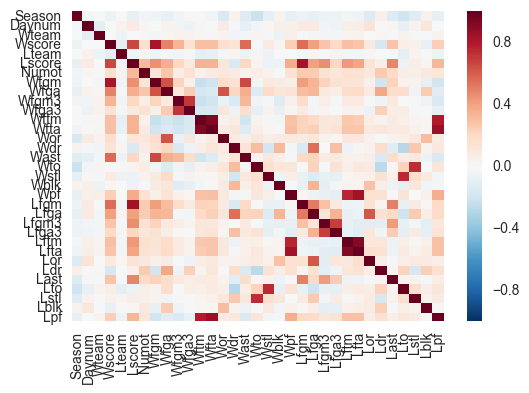

In [43]:
import seaborn as sns
CorrKoef = TourneyDetailedResults.corr()
#pylab.figure(figsize=(50, 25))
sns.heatmap(CorrKoef, annot=False)

In [44]:
RegularSeasonDetailedResults.groupby('Wteam')

In [4]:
RegularSeasonDetailedResults[:10]

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
5,2003,11,1458,81,1186,55,H,0,26,57,...,11,12,17,6,22,8,19,4,3,25
6,2003,12,1161,80,1236,62,H,0,23,55,...,15,20,28,9,21,11,30,10,4,28
7,2003,12,1186,75,1457,61,N,0,28,62,...,17,17,23,8,25,10,15,14,8,18
8,2003,12,1194,71,1156,66,N,0,28,58,...,18,12,27,13,26,13,25,8,2,18
9,2003,12,1458,84,1296,56,H,0,32,67,...,14,7,12,9,23,10,18,1,3,18


In [32]:
Reg[:10]

,Season,Daynum,Wteam,Lteam,Numot,Wfgm,Wfga,Wfgm3,Wfga3,Wftm,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
0,2003,10,1104,1328,0,27,58,3,14,11,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,1393,0,26,62,8,20,10,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1437,1266,0,22,73,3,26,14,...,18,17,29,17,26,15,10,5,2,25
3,2003,11,1296,1457,0,18,38,3,9,17,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,1208,0,30,61,6,14,11,...,16,17,27,21,15,12,10,7,1,14
5,2003,11,1186,1458,0,20,46,3,11,12,...,12,23,27,12,24,12,9,9,3,18
6,2003,12,1161,1236,0,23,55,2,8,32,...,15,20,28,9,21,11,30,10,4,28
7,2003,12,1186,1457,0,28,62,4,14,15,...,17,17,23,8,25,10,15,14,8,18
8,2003,12,1156,1194,0,24,52,6,18,12,...,11,10,18,9,22,9,17,9,2,23
9,2003,12,1296,1458,0,23,52,3,14,7,...,17,15,19,14,22,11,6,12,0,13


In [6]:
del Reg['Wloc']

In [104]:
Reg_y = pd.DataFrame(Reg.Wscore - Reg.Lscore)
Reg_y.columns = ['y']
del Reg['Wscore']
del Reg['Lscore']

# Подсчет статистик по командам 

In [27]:
print len(Reg.Wteam.unique())
len(Reg.Lteam.unique())

355


355

In [177]:
Reg = pd.DataFrame.from_csv("Reg.csv",index_col=None)

In [106]:
col_1 = ['Season','Daynum','Wteam', 'Wfgm', 'Wfga', 'Wfgm3', 'Wfga3', 'Wftm', 'Wfta', 'Wor', 'Wdr', 'Wast', 'Wto', 'Wstl', 'Wblk', 'Wpf']
col_2 = ['Season','Daynum','Lteam','Lfgm', 'Lfga', 'Lfgm3', 'Lfga3', 'Lftm', 'Lfta', 'Lor', 'Ldr', 'Last', 'Lto', 'Lstl', 'Lblk', 'Lpf']
stat_w = Reg.groupby('Wteam').sum() 
for i in col_2:
    del stat_w[i]
stat_w_count = Reg.groupby('Wteam').count()
for i in col_2:
    del stat_w_count[i]


stat_l = Reg.groupby('Lteam').sum()
for i in col_1:
    del stat_l[i]
stat_l_count = Reg.groupby('Lteam').count()
for i in col_1:
    del stat_l_count[i]
stat_l.columns = stat_w.columns
stat_l_count.columns = stat_w_count.columns

stat_w = stat_w + stat_l
stat_w_count = stat_w_count + stat_l_count
stat_w = stat_w * 1.0 / stat_w_count

In [107]:
stat_w['f1'] = stat_w['Wftm'] * 1.0 / stat_w['Wfta']
stat_w['f2'] = stat_w['Wfgm3'] * 1.0 / stat_w['Wfga3']
stat_w['f3'] = stat_w['Wfgm'] * 1.0 / stat_w['Wfga']


In [108]:
del stat_w['Wloc']

In [109]:
stat_w[:5]


,Lscore,Numot,Wast,Wblk,Wdr,Wfga,Wfga3,Wfgm,Wfgm3,Wfta,Wftm,Wor,Wpf,Wscore,Wstl,Wto,f1,f2,f3
Wteam,,,,,,,,,,,,,,,,,,,
1101,68.052632,0.065789,11.710526,1.710526,20.855263,52.513158,18.697368,21.973684,6.947368,19.092105,13.842105,8.157895,21.500000,71.973684,6.171053,13.631579,0.725017,0.371569,0.418441
1102,62.035088,0.040100,13.631579,2.042607,20.328321,47.065163,20.390977,21.436090,7.428571,17.298246,12.010025,6.804511,17.360902,61.944862,6.373434,11.969925,0.694292,0.364307,0.455456
1103,68.828054,0.099548,14.022624,3.597285,22.911765,55.748869,21.081448,24.794118,7.590498,20.875566,14.251131,11.429864,18.995475,68.656109,6.787330,12.984163,0.682670,0.360056,0.444747
1104,67.692130,0.074074,12.166667,4.416667,24.178241,54.837963,17.574074,24.400463,6.006944,20.854167,14.534722,11.678241,17.402778,67.224537,6.868056,13.127315,0.696970,0.341807,0.444956
1105,68.008108,0.059459,11.691892,4.037838,23.294595,56.575676,18.262162,22.432432,5.551351,22.691892,14.867568,12.121622,20.118919,67.354054,7.394595,15.456757,0.655193,0.303981,0.396503


In [110]:
stat_w_tmp = stat_w

In [187]:
(Reg[Reg.Wteam == 1101].Wto.sum() * 1.0 + Reg[Reg.Lteam == 1101].Lto.sum()) *1.0 \
/ (len(Reg[Reg.Wteam == 1101].Wfgm) + len(Reg[Reg.Lteam == 1101].Lfgm)) 

13.631578947368421

In [178]:
Reg = Reg[['Wteam', 'Lteam', 'Season']]
Reg['idx'] = Reg.index
len(Reg.Wteam.unique())

355

In [167]:
len(Reg)

71241

In [143]:
Reg[:1]

,Wteam,Lteam,Season,idx
0,1104,1328,2003,0


In [179]:
Sub = pd.DataFrame.from_csv("SampleSubmission.csv",index_col=None)

In [180]:
for i in Sub.index:
    Sub.ix[i, 'Wteam'] = int(Sub.ix[i,0].split('_')[1])
for i in Sub.index:
    Sub.ix[i, 'Lteam'] = int(Sub.ix[i,0].split('_')[2])
Sub['Season'] = 2017
Sub['idx'] = Sub.index
del Sub['Pred']
del Sub['Id']

In [181]:
Sub.Wteam.unique()

array([ 1112.,  1116.,  1124.,  1137.,  1139.,  1153.,  1166.,  1173.,
        1181.,  1190.,  1195.,  1196.,  1199.,  1211.,  1233.,  1235.,
        1240.,  1242.,  1243.,  1245.,  1246.,  1257.,  1266.,  1268.,
        1274.,  1276.,  1277.,  1278.,  1291.,  1292.,  1297.,  1300.,
        1305.,  1308.,  1309.,  1314.,  1315.,  1321.,  1323.,  1329.,
        1332.,  1343.,  1344.,  1345.,  1348.,  1355.,  1371.,  1374.,
        1376.,  1388.,  1407.,  1411.,  1413.,  1417.,  1423.,  1425.,
        1433.,  1435.,  1436.,  1437.,  1438.,  1439.,  1448.,  1452.,
        1455.,  1457.,  1458.])

In [183]:
Reg = pd.concat([Reg, Sub], axis=0)
    

In [184]:
Reg.index = range(len(Reg))
Reg.idx = Reg.index

In [185]:
len(Reg)

73519

In [186]:
stat_w_good = stat_w

In [187]:
stat_w_good['Wteam'] = stat_w_good.index

In [188]:
Reg = pd.merge(Reg, stat_w_good, on='Wteam').sort(columns=['idx'])
print len(Reg)
del stat_w_good['Wteam']
stat_w_good['Lteam']= stat_w_good.index
Reg = pd.merge(Reg, stat_w, on='Lteam').sort(columns=['idx'])
del stat_w_good['Lteam']

73519


/home/fartuk/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':
/home/fartuk/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [189]:
Reg.index = Reg.idx
del Reg['idx']

In [190]:
len(Reg)

73519

In [18]:
Reg_ch = Reg

#### в плейофф

In [76]:
Reg = pd.DataFrame.from_csv("Reg_playoff.csv",index_col=None)

In [77]:
col_1 = ['Season','Daynum','Wteam', 'Wfgm', 'Wfga', 'Wfgm3', 'Wfga3', 'Wftm', 'Wfta', 'Wor', 'Wdr', 'Wast', 'Wto', 'Wstl', 'Wblk', 'Wpf']
col_2 = ['Season','Daynum','Lteam','Lfgm', 'Lfga', 'Lfgm3', 'Lfga3', 'Lftm', 'Lfta', 'Lor', 'Ldr', 'Last', 'Lto', 'Lstl', 'Lblk', 'Lpf']
stat_w = Reg.groupby('Wteam').sum() 
for i in col_2:
    del stat_w[i]
stat_w_count = Reg.groupby('Wteam').count()
for i in col_2:
    del stat_w_count[i]


stat_l = Reg.groupby('Lteam').sum()
for i in col_1:
    del stat_l[i]
stat_l_count = Reg.groupby('Lteam').count()
for i in col_1:
    del stat_l_count[i]
stat_l.columns = stat_w.columns
stat_l_count.columns = stat_w_count.columns

stat_w = stat_w + stat_l
stat_w_count = stat_w_count + stat_l_count
stat_w = stat_w * 1.0 / stat_w_count

In [78]:
stat_w['f1'] = stat_w['Wftm'] * 1.0 / stat_w['Wfta']
stat_w['f2'] = stat_w['Wfgm3'] * 1.0 / stat_w['Wfga3']
stat_w['f3'] = stat_w['Wfgm'] * 1.0 / stat_w['Wfga']

In [79]:
del stat_w['Wloc']


In [80]:
stat_w.columns = stat_w.columns + '_in'

In [81]:
stat_w = pd.concat([stat_w,stat_w_tmp], axis=1)

In [82]:
stat_w_good = stat_w

In [87]:
stat_w_good[:5]

,Lscore_in,Numot_in,Wast_in,Wblk_in,Wdr_in,Wfga_in,Wfga3_in,Wfgm_in,Wfgm3_in,Wfta_in,...,Wftm,Wor,Wpf,Wscore,Wstl,Wto,f1,f2,f3,Wteam
1101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.842105,8.157895,21.500000,71.973684,6.171053,13.631579,0.725017,0.371569,0.418441,1101
1102,65.000000,0.0,15.000000,1.500000,16.500000,40.000000,26.0,19.000000,10.500000,15.500000,...,12.010025,6.804511,17.360902,61.944862,6.373434,11.969925,0.694292,0.364307,0.455456,1102
1103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.251131,11.429864,18.995475,68.656109,6.787330,12.984163,0.682670,0.360056,0.444747,1103
1104,70.888889,0.0,12.777778,4.444444,21.111111,50.222222,18.0,23.111111,6.777778,22.333333,...,14.534722,11.678241,17.402778,67.224537,6.868056,13.127315,0.696970,0.341807,0.444956,1104
1105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.867568,12.121622,20.118919,67.354054,7.394595,15.456757,0.655193,0.303981,0.396503,1105


In [85]:
Reg = Reg[['Wteam', 'Lteam', 'Season']]
Reg['idx'] = Reg.index
len(Reg.Wteam.unique())

196

In [86]:
stat_w_good['Wteam'] = stat_w_good.index

In [89]:
Reg = pd.merge(Reg, stat_w_good, on='Wteam').sort(columns=['idx'])
del stat_w_good['Wteam']
stat_w_good['Lteam']= stat_w_good.index
Reg = pd.merge(Reg, stat_w, on='Lteam').sort(columns=['idx'])
del stat_w_good['Lteam']

/home/fartuk/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':
/home/fartuk/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [91]:
Reg.index = Reg.idx
del Reg['idx']

In [93]:
Reg[:3]

,Wteam,Lteam,Season,Lscore_in_x,Numot_in_x,Wast_in_x,Wblk_in_x,Wdr_in_x,Wfga_in_x,Wfga3_in_x,...,Wfta_y,Wftm_y,Wor_y,Wpf_y,Wscore_y,Wstl_y,Wto_y,f1_y,f2_y,f3_y
idx,,,,,,,,,,,,,,,,,,,,,
0,1411,1421,2003,81.666667,0.333333,11.000000,1.333333,18.333333,56.000000,18.666667,...,21.577215,15.410127,11.513924,17.974684,72.754430,7.397468,15.050633,0.714185,0.341347,0.439538
1,1436,1112,2003,62.142857,0.142857,11.142857,1.428571,20.428571,61.714286,20.285714,...,22.648770,16.449664,11.731544,16.863535,71.796421,6.586130,13.058166,0.726294,0.372087,0.466868
2,1272,1113,2003,68.769231,0.038462,13.307692,4.730769,22.576923,58.076923,18.192308,...,20.967517,14.526682,10.331787,18.211137,68.684455,5.995360,13.313225,0.692818,0.352021,0.446391


In [94]:
Reg_playoff = Reg

In [105]:
print Reg_playoff.shape
print Reg_ch.shape

(914, 79)
(71241, 79)


In [106]:
Reg = pd.concat([Reg_ch,Reg_playoff], axis=0)

In [113]:
print Reg.shape

(72155, 805)


In [108]:
Reg.to_csv('Reg_all.csv', index=False)

In [196]:
Reg_ch = pd.DataFrame.from_csv("Reg.csv",index_col=None)
Reg_y_ch = pd.DataFrame(Reg_ch.Wscore - Reg_ch.Lscore)
Reg_y_ch.columns = ['y']

Reg_playoff = pd.DataFrame.from_csv("Reg_playoff.csv",index_col=None)
Reg_y_playoff = pd.DataFrame(Reg_playoff.Wscore - Reg_playoff.Lscore)
Reg_y_playoff.columns = ['y']

In [200]:
Reg_y = Reg_y_ch

In [126]:
Reg_y = pd.concat([Reg_y_ch, Reg_y_playoff], axis=0)

In [127]:
Reg_y.to_csv('Reg_y.csv', index=False)

добавление всех команд для onehot

In [191]:
all_team = pd.DataFrame(Teams.Team_Id)
all_team = pd.concat([all_team,all_team], axis=1)
all_team.columns = ['Wteam', 'Lteam']
Reg = pd.concat([Reg, all_team], axis=0)

In [192]:
tmp_w = pd.get_dummies(Reg.loc[:, 'Wteam'])
tmp_l = pd.get_dummies(Reg.loc[:, 'Lteam'])
tmp_l.columns = tmp_l.columns * - 1
del Reg['Wteam']
del Reg['Lteam']

Reg = pd.concat([Reg, tmp_w, tmp_l], axis=1)

In [193]:
Reg = Reg[:len(Reg) - 364]

In [194]:
Reg.index = range(len(Reg))

In [153]:
Reg.to_csv('Reg_all_fin.csv', index=False)

In [166]:
Reg.fillna(0, inplace=True)

In [195]:
Reg[:5]

,Lscore_x,Lscore_y,Numot_x,Numot_y,Season,Wast_x,Wast_y,Wblk_x,Wblk_y,Wdr_x,...,-1455.0,-1456.0,-1457.0,-1458.0,-1459.0,-1460.0,-1461.0,-1462.0,-1463.0,-1464.0
0,67.692130,69.173210,0.074074,0.057737,2003.0,12.166667,13.588915,4.416667,3.861432,24.178241,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,70.403509,69.542222,0.039474,0.064444,2003.0,15.008772,15.588889,5.719298,6.002222,25.129386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,70.825397,70.688787,0.058957,0.077803,2003.0,13.834467,15.082380,3.766440,3.260870,24.349206,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,66.894089,66.265509,0.071429,0.076923,2003.0,12.000000,12.176179,3.236453,3.684864,22.901478,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,69.752784,67.976798,0.080178,0.090487,2003.0,13.227171,12.756381,5.080178,4.243619,25.596882,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [221]:
Train = Reg[Reg.Season <= 2016]
#Test = Reg[Reg.Season < 2015][Reg.Season <= 2003]
Valid = Reg[Reg.Season == 2017]
del Train['Season']
#del Test['Season']
del Valid['Season']

Train_y = Reg_y[:len(Train)]
#Test_y = Reg_y[len(Train) + 1:len(Train)+len(Test) + 1]
Valid_y = Reg_y[-len(Valid):]


#Test_y.index = range(len(Test))
Valid_y.index = range(len(Valid))

In [222]:
Valid_y_bit = []
for i in Valid_y.index:
    if Valid_y.ix[i, 'y'] > 0:
        Valid_y_bit += [1.0]
    else:
        Valid_y_bit += [0.0]
Test_y_bit = []
for i in Test_y.index:
    if Test_y.ix[i, 'y'] > 0:
        Test_y_bit += [1.0]
    else:
        Test_y_bit += [0.0]
Train_y_bit = []
for i in Train_y.index:
    if Train_y.ix[i, 'y'] > 0:
        Train_y_bit += [1.0]
    else:
        Train_y_bit += [0.0]

In [223]:
print Train.shape
print Test.shape
print Valid.shape

print Reg_y.shape

(71241, 766)
(4616, 766)
(2278, 766)
(71241, 1)


In [224]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(Train, Train_y)
Train = scaler.transform(Train)
Train = pd.DataFrame(Train)
Test = scaler.transform(Test)
Test = pd.DataFrame(Test)
Valid = scaler.transform(Valid)
Valid = pd.DataFrame(Valid)

### Линейная модель

In [209]:
lin = sklearn.linear_model.LinearRegression()

In [210]:
lin.fit(Train, Train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [211]:
lin_pred = pd.DataFrame(lin.predict(Valid), columns=['pre'])

In [212]:
pd.concat([lin_pred, Valid_y], axis=1)[-10:]

,pre,y
5359,-6.849867,6
5360,0.672106,-33
5361,-3.074965,11
5362,-2.107435,-22
5363,-0.225844,3
5364,4.859117,20
5365,-1.864515,-14
5366,8.429918,5
5367,4.836656,4
5368,1.727281,-13


In [213]:
print lin_pred.max()
print lin_pred.min()

pre    37.612047
dtype: float64
pre   -35.612562
dtype: float64


Подбор сигмоиды

In [214]:
min_val = 1.0
a = 0.01
for i in np.linspace(0.01, 1.1, 100):
    def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-i*x))
    otv = sigmoid(lin_pred)
    tmp = log_loss(pd.DataFrame(Valid_y_bit), otv)
    if tmp < min_val:
        min_val = tmp
        a = i
print min_val
print a

0.613961517055
0.109090909091


In [222]:
o = []
for i in otv.pre:
    o += [0.5]

In [223]:
log_loss(pd.DataFrame(Valid_y_bit), pd.DataFrame(o))

0.69314718055994529

### XGB

In [225]:
dtrain = xgb.DMatrix(data = Train, label = Train_y)

In [226]:
param = {'min_child_weight': 100,
        'eta': 0.3,
        #'colsample_bytree': 0.9,
        'max_depth': 5,
        #'subsample': 0.3,
        'alpha': 1,
        'gamma': 1,
        'silent': 1,
        'objective': 'reg:linear',
        'verbose_eval': True}
num_round = 70

In [227]:
bst = xgb.train(param, dtrain, num_round)


In [238]:
boost_pred = bst.predict(xgb.DMatrix(data = Valid))


In [219]:
min_val = 1.0
a = 0.01
for i in np.linspace(0, 1.1, 100):
    def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-i*x))
    otv = sigmoid(boost_pred)
    tmp = log_loss(pd.DataFrame(Valid_y_bit), otv)
    if tmp < min_val:
        min_val = tmp
        a = i
print min_val
print a

0.611373109698
0.122222222222


In [ ]:
0.61135886733
0.612736313283

In [239]:
len(boost_pred)

2278

In [240]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-0.122*x))
otv = sigmoid(boost_pred)

In [241]:
len(otv)

2278

In [244]:
Sub = pd.DataFrame.from_csv("SampleSubmission.csv",index_col=None)
Sub.Pred = otv
len(Sub)

2278

In [246]:
# Итоговые предсказания
Sub[:20]

,Id,Pred
0,2017_1112_1116,0.659465
1,2017_1112_1124,0.663233
2,2017_1112_1137,0.800348
3,2017_1112_1139,0.657611
4,2017_1112_1153,0.570716
5,2017_1112_1166,0.723217
6,2017_1112_1173,0.719898
7,2017_1112_1181,0.257752
8,2017_1112_1190,0.918038
9,2017_1112_1195,0.940902


In [247]:
Sub.to_csv('MySub.csv', index=False)

In [250]:
clf = xgb.XGBClassifier(max_depth=8,
                        learning_rate=0.2,
                        n_estimators=45,
                        silent=True,
                        objective='binary:logistic',
                        nthread=-1,
                        #gamma=0,
                        min_child_weight=100,
                        #max_delta_step=0,
                        subsample=0.83,
                        #colsample_bytree=1,
                        #colsample_bylevel=1,
                        #reg_alpha=0,
                        #reg_lambda=1,
                        #scale_pos_weight=1,
                        #base_score=0.5,
                        seed=10,
                        missing=None)

In [251]:
clf.fit(Train, Train_y_bit)




XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=8,
       min_child_weight=100, missing=None, n_estimators=45, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=10, silent=True, subsample=0.83)

In [252]:
log_loss(pd.DataFrame(Test_y_bit), clf.predict_proba(Test))

0.81790152496892199

## RandomForest

In [73]:
import sklearn
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
forest_regressor = sklearn.ensemble.RandomForestRegressor(n_estimators=295,
                                       #criterion='mlog_loss',
                                       max_depth=8,
                                       min_samples_split=10,
                                       min_samples_leaf=7,
                                       #min_weight_fraction_leaf=0.0,
                                       max_features='auto',
                                       max_leaf_nodes=None,
                                       bootstrap=True,
                                       #oob_score=False,
                                       n_jobs=-1,
                                       random_state=13)

In [74]:
forest_regressor.fit(Train, Train_y)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=7,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=295, n_jobs=-1, oob_score=False, random_state=13,
           verbose=0, warm_start=False)

In [75]:
forest_pred = forest_regressor.predict(Test)

In [76]:
min_val = 1.0
a = 0.01
for i in np.linspace(0.01, 1.1, 100):
    def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-i*x))
    otv = sigmoid(forest_pred)
    tmp = log_loss(pd.DataFrame(Test_y_bit), otv)
    if tmp < min_val:
        min_val = tmp
        a = i
print min_val
print a

0.620726137321
0.131111111111


In [158]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-0.1*x))

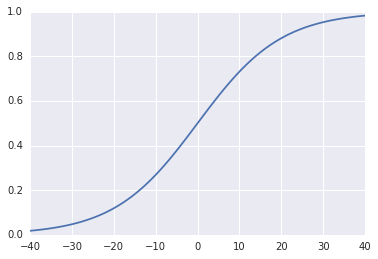

In [159]:
bins = np.linspace(-40, 40, 100)
plt.plot(bins, sigmoid(bins), label='F')

In [160]:
otv = sigmoid(lin_pred)

In [161]:
otv[:10]

,pre
0,0.071240
1,0.802522
2,0.164756
3,0.237114
4,0.913305
5,0.530184
6,0.296610
7,0.226336
8,0.607892
9,0.885452


In [162]:
log_loss(pd.DataFrame(Test_y_bit), otv)

0.613034731010211